In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Data Preparation

## Data Loading

In [3]:
# Loads in the fighter-stats df
fighters = pd.read_csv("../data/fighter-stats-threading.csv")
fighters

,Full Name,Height(inches),Weight(lbs),Reach(inches),Stance,DOB,SLpM.,Str.Acc.,SApM,Str.Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,Record
0,Tom Aaron,NaN,155.0,NaN,NaN,"Jul 13, 1978",0.00,0%,0.00,0%,0.00,0%,0%,0.0,Record: 5-3-0
1,Danny Abbadi,5' 11,155.0,NaN,Orthodox,"Jul 03, 1983",3.29,38%,4.41,57%,0.00,0%,77%,0.0,Record: 4-6-0
2,Nariman Abbasov,5' 8,155.0,66.0,Orthodox,"Feb 01, 1994",3.00,20%,5.67,46%,0.00,0%,66%,0.0,Record: 28-4-0
3,David Abbott,6' 0,265.0,NaN,Switch,NaN,1.35,30%,3.55,38%,1.07,33%,66%,0.0,Record: 10-15-0
4,Hamdy Abdelwahab,6' 2,264.0,72.0,Southpaw,"Jan 22, 1993",3.87,52%,3.13,59%,3.00,75%,0%,0.0,Record: 5-0-0 (1 NC)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4217,Dave Zitanick,NaN,170.0,NaN,NaN,"Mar 05, 1980",0.00,0%,0.00,0%,0.00,0%,0%,0.0,Record: 5-7-0 (1 NC)
4218,Alex Zuniga,NaN,145.0,NaN,NaN,NaN,0.00,0%,0.00,0%,0.00,0%,0%,0.0,Record: 6-3-0
4219,George Zuniga,5' 9,185.0,NaN,NaN,NaN,7.64,38%,5.45,37%,0.00,0%,100%,0.0,Record: 3-1-0
4220,Allan Zuniga,5' 7,155.0,70.0,Orthodox,"Apr 04, 1992",3.93,52%,1.80,61%,0.00,0%,57%,1.0,Record: 13-1-0


## Basic Data Transformation

In [4]:
# Seperate the record into w, l, d and make three new columns
pattern = r"Record:\s(\d+)-(\d+)-(\d+)"
fighters[['win', 'loss', 'draw']] = fighters['Record'].str.extract(pattern).astype(int)
# Drop the record column
fighters = fighters.drop('Record', axis=1)

# Takes in height in ft and convert it to inches
def convert_to_inches(string):
    if pd.isna(string):
         return string
    string_list = string.split("'")
    ft = int(string_list[0].strip())
    inches = int(string_list[1].replace("\"", "").strip())
    return ft * 12 + inches
# Convert height to inches
fighters['Height(inches)'] = fighters['Height(inches)'].apply(convert_to_inches) 
# Rename column names
fighters = fighters.rename(columns={'Height(inches)': 'Height', 'Weight(lbs)': 'Weight', 'Reach(inches)': 'Reach'})

# Convert DOB column to datetime
fighters['DOB'] = pd.to_datetime(fighters['DOB'])
# Calculate age
today = datetime.today()
fighters['DOB'] = fighters['DOB'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))
# Rename DOB column to age
fighters.rename(columns={'DOB': 'Age'}, inplace=True)

# Convert percentages to float numbers
def percentages_to_float(column):
    return column.str.rstrip('%').astype(float) / 100
fighters[['Str.Acc.', 'Str.Def', 'TD Acc.', 'TD Def.']] = fighters[['Str.Acc.', 'Str.Def', 'TD Acc.', 'TD Def.']].apply(percentages_to_float)

## Handling Missing Data

In [5]:
# Impute missing height with weight class average height
fighters['Height'] = fighters.groupby('Weight')['Height'].transform(
    lambda x: x.fillna(x.mean())
)

# Impute missing reach with weight class average reach
fighters['Reach'] = fighters.groupby('Weight')['Reach'].transform(
    lambda x: x.fillna(x.mean())
)

# Drop rows with missing weight because it's a low percentage (2%)
fighters = fighters[~fighters['Weight'].isnull()]

# Impute missing stance value with the mode
fighters['Stance'] = fighters['Stance'].fillna('Orthodox')

# Every fight starts on the feet. If a fighter is has all the striking stats as 0,
# that most likely mean the fighter is insignificant.
# Therefore, we can just remove those fighters
columns_to_check = ['SLpM.', 'Str.Acc.', 'SApM', 'Str.Def']
fighters = fighters[(fighters['SLpM.'] > 0) & (fighters['Str.Acc.'] > 0) & (fighters['SApM'] > 0) & (fighters['Str.Def'] > 0)]
fighters.drop('Age', axis=1, inplace=True)

In [6]:
fighters

,Full Name,Height,Weight,Reach,Stance,SLpM.,Str.Acc.,SApM,Str.Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,win,loss,draw
1,Danny Abbadi,71.0,155.0,71.576503,Orthodox,3.29,0.38,4.41,0.57,0.00,0.00,0.77,0.0,4,6,0
2,Nariman Abbasov,68.0,155.0,66.000000,Orthodox,3.00,0.20,5.67,0.46,0.00,0.00,0.66,0.0,28,4,0
3,David Abbott,72.0,265.0,77.871795,Switch,1.35,0.30,3.55,0.38,1.07,0.33,0.66,0.0,10,15,0
4,Hamdy Abdelwahab,74.0,264.0,72.000000,Southpaw,3.87,0.52,3.13,0.59,3.00,0.75,0.00,0.0,5,0,0
5,Mansur Abdul-Malik,74.0,185.0,79.000000,Orthodox,6.61,0.54,4.21,0.53,0.00,0.00,0.75,0.0,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213,James Zikic,74.0,205.0,75.846154,Orthodox,1.47,0.35,1.60,0.44,0.50,0.25,0.74,0.5,21,10,2
4215,Cat Zingano,66.0,145.0,68.000000,Southpaw,2.57,0.61,1.63,0.47,2.77,0.65,0.42,0.8,10,4,0
4219,George Zuniga,69.0,185.0,75.077821,Orthodox,7.64,0.38,5.45,0.37,0.00,0.00,1.00,0.0,3,1,0
4220,Allan Zuniga,67.0,155.0,70.000000,Orthodox,3.93,0.52,1.80,0.61,0.00,0.00,0.57,1.0,13,1,0


## Missing Data Edge Cases

In [7]:
# Some fighters are in their own weight because of their unique weight. We just simplay remove those 131 entries
fighters = fighters[~fighters['Reach'].isnull()]

I decided to drop the Stance column all together.
If I were to perform one-hot encoding on this categorizal column, I would create 10 additional columns just for one feature, which might cause linear independence and might oversaturate the dimensions, impacting model performance.

In [8]:
# Drop the stance column
fighters.drop('Stance', axis=1, inplace=True)

/var/folders/hs/p1v1mb2d2vq178t86rn3t26w0000gn/T/ipykernel_78769/3959195240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fighters.drop('Stance', axis=1, inplace=True)


In [9]:
fighters

,Full Name,Height,Weight,Reach,SLpM.,Str.Acc.,SApM,Str.Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,win,loss,draw
1,Danny Abbadi,71.0,155.0,71.576503,3.29,0.38,4.41,0.57,0.00,0.00,0.77,0.0,4,6,0
2,Nariman Abbasov,68.0,155.0,66.000000,3.00,0.20,5.67,0.46,0.00,0.00,0.66,0.0,28,4,0
3,David Abbott,72.0,265.0,77.871795,1.35,0.30,3.55,0.38,1.07,0.33,0.66,0.0,10,15,0
4,Hamdy Abdelwahab,74.0,264.0,72.000000,3.87,0.52,3.13,0.59,3.00,0.75,0.00,0.0,5,0,0
5,Mansur Abdul-Malik,74.0,185.0,79.000000,6.61,0.54,4.21,0.53,0.00,0.00,0.75,0.0,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213,James Zikic,74.0,205.0,75.846154,1.47,0.35,1.60,0.44,0.50,0.25,0.74,0.5,21,10,2
4215,Cat Zingano,66.0,145.0,68.000000,2.57,0.61,1.63,0.47,2.77,0.65,0.42,0.8,10,4,0
4219,George Zuniga,69.0,185.0,75.077821,7.64,0.38,5.45,0.37,0.00,0.00,1.00,0.0,3,1,0
4220,Allan Zuniga,67.0,155.0,70.000000,3.93,0.52,1.80,0.61,0.00,0.00,0.57,1.0,13,1,0


## Perform Join

In [11]:
# Load in the fights dataset that includes all the fight matchups
fights = pd.read_csv("../data/fight-matchups.csv")
fights.head(10)

,fighter1,fighter2
0,Petr Yan,Deiveson Figueiredo
1,Yan Xiaonan,Tabatha Ricci
2,Muslim Salikhov,Song Kenan
3,Gabriella Fernandes,Wang Cong
4,Carlos Ulberg,Volkan Oezdemir
5,Zhang Mingyang,Ozzy Diaz
6,SuYoung You,Baergeng Jieleyisi
7,DongHun Choi,Kiru Sahota
8,Shi Ming,Feng Xiaocan
9,Carlos Hernandez,Nyamjargal Tumendemberel


In [12]:
# Merged the tables and rename them
matchups = fights.merge(fighters, left_on = 'fighter1', right_on = 'Full Name')
matchups = matchups.merge(fighters, left_on = 'fighter2', right_on = 'Full Name')
matchups = matchups.drop(columns=['fighter1', 'fighter2', 'Full Name_x', 'Full Name_y'])
matchups.columns
matchups = matchups.rename(columns={'Height_x': 'height1', 'Weight_x': 'weight1', 'Reach_x': 'reach1', 'SLpM._x': 'slpm1', 'Str.Acc._x': 'stracc1', 
                                    'SApM_x': 'sapm1', 'Str.Def_x': 'strdef1', 'TD Avg._x': 'tdavg1', 'TD Acc._x': 'tdacc1', 'TD Def._x': 'tddef1',
                                    'Sub. Avg._x': 'subavg1', 'win_x': 'win1', 'loss_x': 'loss1', 'draw_x': 'draw1'})
matchups = matchups.rename(columns={'Height_y': 'height2', 'Weight_y': 'weight2', 'Reach_y': 'reach2', 'SLpM._y': 'slpm2', 'Str.Acc._y': 'stracc2', 
                                    'SApM_y': 'sapm2', 'Str.Def_y': 'strdef2', 'TD Avg._y': 'tdavg2', 'TD Acc._y': 'tdacc2', 'TD Def._y': 'tddef2',
                                    'Sub. Avg._y': 'subavg2', 'win_y': 'win2', 'loss_y': 'loss2', 'draw_y': 'draw2'})
display(matchups)

,height1,weight1,reach1,slpm1,stracc1,sapm1,strdef1,tdavg1,tdacc1,tddef1,...,stracc2,sapm2,strdef2,tdavg2,tdacc2,tddef2,subavg2,win2,loss2,draw2
0,67.0,135.0,67.000000,5.11,0.54,4.13,0.58,1.61,0.49,0.84,...,0.54,3.55,0.49,1.62,0.34,0.60,1.4,24,4,1
1,65.0,115.0,63.000000,4.99,0.45,3.44,0.60,0.92,0.73,0.63,...,0.36,5.29,0.57,2.74,0.37,0.81,0.1,11,3,0
2,71.0,170.0,70.000000,3.38,0.49,2.90,0.62,1.08,0.32,0.72,...,0.46,5.82,0.51,0.42,0.30,0.73,0.0,22,9,0
3,66.0,125.0,66.000000,3.46,0.46,5.50,0.49,0.56,0.18,0.60,...,0.46,1.63,0.70,1.16,0.50,1.00,2.3,6,1,0
4,76.0,205.0,77.000000,7.20,0.56,4.27,0.50,0.72,0.75,0.83,...,0.48,4.22,0.55,0.50,0.29,0.80,0.1,20,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7561,70.0,170.0,73.564103,1.79,0.45,1.66,0.63,1.96,1.00,0.54,...,0.40,0.97,0.50,0.00,0.00,0.25,2.1,21,13,1
7562,73.0,205.0,75.000000,2.85,0.57,1.53,0.59,2.78,0.46,0.58,...,0.46,2.83,0.50,1.02,0.60,0.53,0.6,26,14,0
7563,72.0,185.0,74.000000,1.59,0.46,2.83,0.50,1.02,0.60,0.53,...,0.30,3.55,0.38,1.07,0.33,0.66,0.0,10,15,0
7564,73.0,205.0,75.000000,1.88,0.52,2.62,0.40,3.89,0.40,0.50,...,0.56,2.14,0.48,0.40,1.00,0.53,0.8,23,22,1


## Flip the dataframe

In [13]:
half = len(matchups.columns) // 2  # Number of columns to split

# The first half of the dataframe that contains only information for fighter1
matchups_first_half = matchups.iloc[:, :half]  # First half

# The second half of the dataframe that contains only information for fighter2
matchups_second_half = matchups.iloc[:, half:]  # Second half

# Flips them by putting the second half first
matchups_reversed = pd.concat([matchups_second_half, matchups_first_half], axis=1)

# Rename the columns
matchups_reversed.columns = matchups.columns
display(matchups_reversed)

,height1,weight1,reach1,slpm1,stracc1,sapm1,strdef1,tdavg1,tdacc1,tddef1,...,stracc2,sapm2,strdef2,tdavg2,tdacc2,tddef2,subavg2,win2,loss2,draw2
0,65.0,135.0,68.000000,2.91,0.54,3.55,0.49,1.62,0.34,0.60,...,0.54,4.13,0.58,1.61,0.49,0.84,0.1,18,5,0
1,61.0,115.0,61.000000,4.18,0.36,5.29,0.57,2.74,0.37,0.81,...,0.45,3.44,0.60,0.92,0.73,0.63,0.0,19,4,0
2,72.0,170.0,71.000000,4.49,0.46,5.82,0.51,0.42,0.30,0.73,...,0.49,2.90,0.62,1.08,0.32,0.72,0.0,21,5,0
3,66.0,125.0,66.000000,5.81,0.46,1.63,0.70,1.16,0.50,1.00,...,0.46,5.50,0.49,0.56,0.18,0.60,0.3,10,3,0
4,74.0,205.0,75.000000,4.95,0.48,4.22,0.55,0.50,0.29,0.80,...,0.56,4.27,0.50,0.72,0.75,0.83,0.2,12,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7561,68.0,170.0,73.564103,0.60,0.40,0.97,0.50,0.00,0.00,0.25,...,0.45,1.66,0.63,1.96,1.00,0.54,1.0,29,7,2
7562,72.0,185.0,74.000000,1.59,0.46,2.83,0.50,1.02,0.60,0.53,...,0.57,1.53,0.59,2.78,0.46,0.58,0.5,19,11,0
7563,72.0,265.0,77.871795,1.35,0.30,3.55,0.38,1.07,0.33,0.66,...,0.46,2.83,0.50,1.02,0.60,0.53,0.6,26,14,0
7564,75.0,249.0,76.500000,1.84,0.56,2.14,0.48,0.40,1.00,0.53,...,0.52,2.62,0.40,3.89,0.40,0.50,0.8,16,10,0


## Stack the two tables on top of each other

In [14]:
matchups_total = pd.concat([matchups, matchups_reversed], ignore_index=True)
display(matchups_total)

,height1,weight1,reach1,slpm1,stracc1,sapm1,strdef1,tdavg1,tdacc1,tddef1,...,stracc2,sapm2,strdef2,tdavg2,tdacc2,tddef2,subavg2,win2,loss2,draw2
0,67.0,135.0,67.000000,5.11,0.54,4.13,0.58,1.61,0.49,0.84,...,0.54,3.55,0.49,1.62,0.34,0.60,1.4,24,4,1
1,65.0,115.0,63.000000,4.99,0.45,3.44,0.60,0.92,0.73,0.63,...,0.36,5.29,0.57,2.74,0.37,0.81,0.1,11,3,0
2,71.0,170.0,70.000000,3.38,0.49,2.90,0.62,1.08,0.32,0.72,...,0.46,5.82,0.51,0.42,0.30,0.73,0.0,22,9,0
3,66.0,125.0,66.000000,3.46,0.46,5.50,0.49,0.56,0.18,0.60,...,0.46,1.63,0.70,1.16,0.50,1.00,2.3,6,1,0
4,76.0,205.0,77.000000,7.20,0.56,4.27,0.50,0.72,0.75,0.83,...,0.48,4.22,0.55,0.50,0.29,0.80,0.1,20,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15127,68.0,170.0,73.564103,0.60,0.40,0.97,0.50,0.00,0.00,0.25,...,0.45,1.66,0.63,1.96,1.00,0.54,1.0,29,7,2
15128,72.0,185.0,74.000000,1.59,0.46,2.83,0.50,1.02,0.60,0.53,...,0.57,1.53,0.59,2.78,0.46,0.58,0.5,19,11,0
15129,72.0,265.0,77.871795,1.35,0.30,3.55,0.38,1.07,0.33,0.66,...,0.46,2.83,0.50,1.02,0.60,0.53,0.6,26,14,0
15130,75.0,249.0,76.500000,1.84,0.56,2.14,0.48,0.40,1.00,0.53,...,0.52,2.62,0.40,3.89,0.40,0.50,0.8,16,10,0


# Step 2: Exploratory Data Analysis

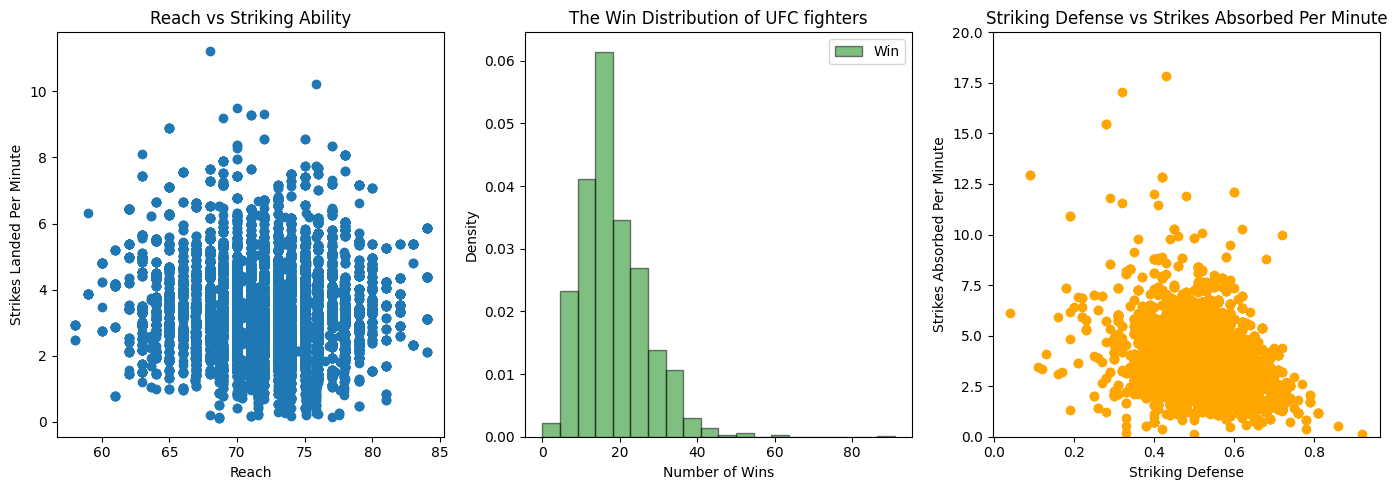

In [15]:
# Create a figure with 9 potential subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

# Create a scatter plot to see if a longer reach makes you a better striker
ax1.scatter(x=matchups_total['reach1'], y=matchups_total['slpm1'])
ax1.set_xlabel('Reach')
ax1.set_ylabel('Strikes Landed Per Minute')
ax1.set_title('Reach vs Striking Ability')

# Create a overlay histogram to see the win distribution of the UFC roster
ax2.hist(matchups_total['win1'], bins=20, alpha=0.5, color='g', edgecolor='black', label='Win', density=True)
ax2.set_xlabel('Number of Wins')
ax2.set_ylabel('Density')
ax2.set_title('The Win Distribution of UFC fighters')
ax2.legend()

# Create a scatter plot to see the relationship between striking defense and strikes absorbed per minute
ax3.scatter(x=matchups_total['strdef1'], y=matchups_total['sapm1'], color='orange')
ax3.set_ylim(0, 20)
ax3.set_title('Striking Defense vs Strikes Absorbed Per Minute')
ax3.set_xlabel('Striking Defense')
ax3.set_ylabel('Strikes Absorbed Per Minute')


plt.tight_layout()
plt.show()

## Heat Map

<Axes: >

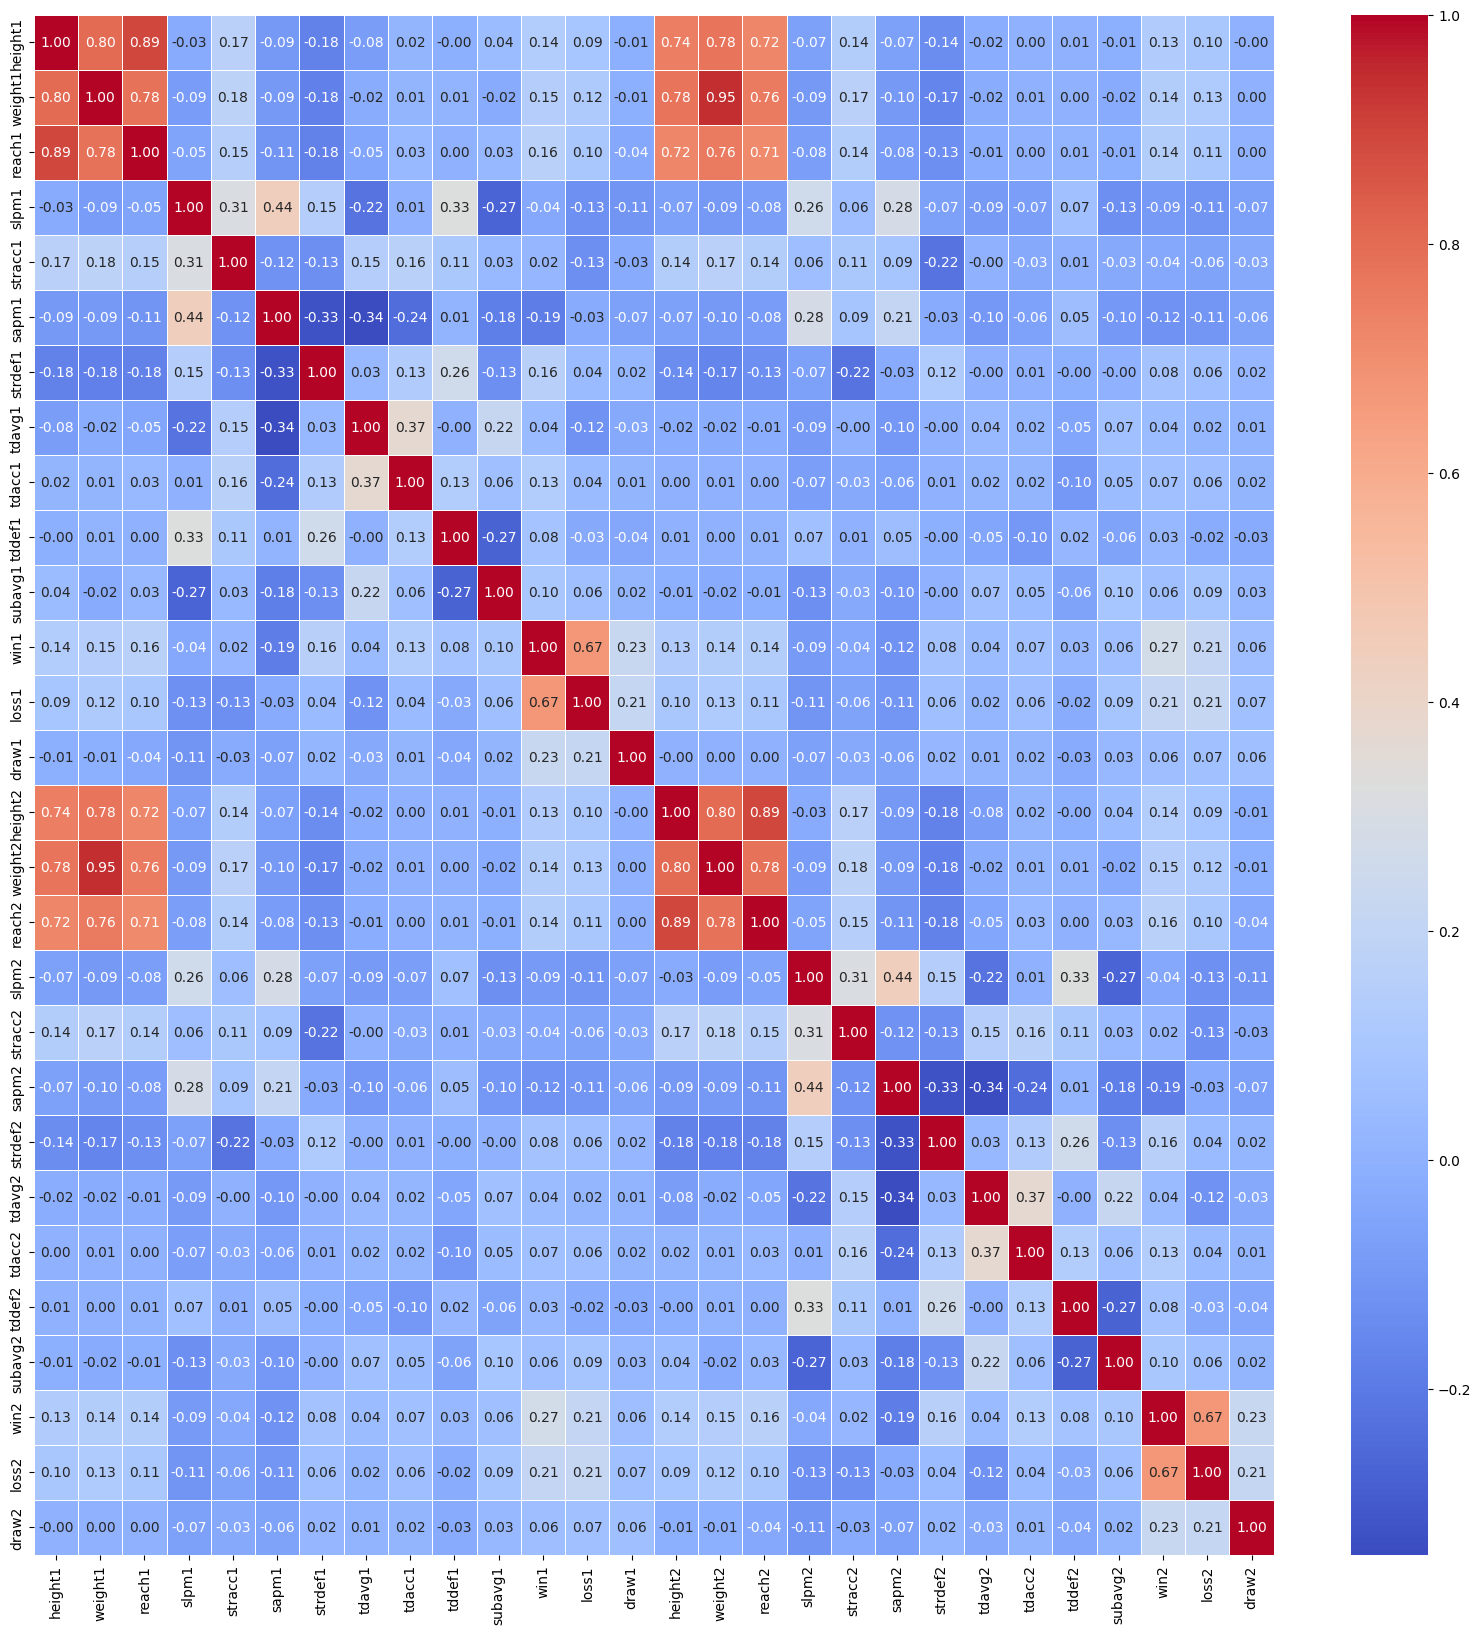

In [16]:
# Produce the correlation matrix
correlation_matrix = matchups_total.corr()

plt.figure(figsize=(20, 20))

# Use the correlation matrix to plot the heat map
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

## Heatmap Conclusion

1. Eliminate the win and draw columns. Having all win, loss, and draw create multicollinearity. I believe that loss is more important because wins are inflated since most fighters have lots of wins before coming to the ufc.
2. Drop the weight, reach, and height columns, and use their differences instead.

# Data Pipeline

In [17]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

## Create target variable and datasets

In [18]:
# Calculate half of the number of rows of the data frame
n = len(matchups_total) // 2

# Create n number of ones and n number of zeros and put them in a series
arr = np.concatenate([np.ones(n), np.zeros(n)])

# Convert it to a Pandas Series
series = pd.Series(arr)

# Create the X and Y dataset
X = matchups_total
y = series

## Custom Transformation class

In [19]:
# Create custom data transformation class to apply the heat map conclusions
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Drop the win and draw columns
        X = X.drop(columns=['win1', 'draw1', 'win2', 'draw2'])

        # Difference in the amount of losses
        X['loss_difference'] = X['loss1'] - X['loss2']

        # Drop the loss columns
        X.drop(columns=['loss1', 'loss2'])

        # Drop the striking defense, and keep only strikes absorbed per minute column
        X = X.drop(columns=['strdef1', 'strdef2'])
        
        # Difference in height (and drop individual columns)
        X['height_difference'] = X['height1'] - X['height2']
        X = X.drop(columns=['height1', 'height2'])
        
        # Drop the weight columns
        X = X.drop(columns=['weight1', 'weight2'])
        
        # Difference in reach (and drop individual columns)
        X['reach_difference'] = X['reach1'] - X['reach2']
        X = X.drop(columns=['reach1', 'reach2'])

        # Create multiplication of different features
        X['sapm_*'] = X['sapm1'] * X['sapm2']
        X = X.drop(columns=['sapm1', 'sapm2'])

        X['tdavg_*'] = X['tdavg1'] * X['tdavg2']
        X = X.drop(columns=['tdavg1', 'tdavg2'])
        return X

## Train Test Split

In [20]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Create the pipeline and param_grid for logistic regression

In [23]:
# Define the pipeline with Feature Engineering, StandardScaler, PCA, and Logistic Regression
pipeline = Pipeline([
    # ('feature_engineering', FeatureEngineer()),   # Step 1: Feature Engineering
    ('scaler', StandardScaler()),                # Step 2: Standardize the data
    ('pca', PCA()),                              # Step 3: PCA (Dimensionality Reduction)
    ('log_reg', LogisticRegression(penalty='l1', solver='liblinear'))  # Step 4: Lasso Logistic Regression (L1 penalty)
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'pca__n_components': list(range(2, 29)),           # Number of PCA components
    'log_reg__C': np.linspace(0.001, 10, 10)          # Regularization strength for Lasso Logistic Regression
}

## Create the pipeline and param_grid for XGBoost

In [21]:
# Define the pipeline with Feature Engineering, StandardScaler, PCA, and XGB
pipeline = Pipeline([
    # ('feature_engineering', FeatureEngineer()),   # Step 1: Feature Engineering
    ('scaler', StandardScaler()),                # Step 2: Standardize the data
    ('pca', PCA()),                              # Step 3: PCA (Dimensionality Reduction)
    ('xgb', xgb.XGBClassifier())                 # Step 4: XGBoost Classifier
])

# Define the parameter grid for GridSearchCV (XGBoost-specific hyperparameters)
param_grid = {
    'pca__n_components': list(range(2, 29)),                  # Number of PCA components
    'xgb__n_estimators': [50, 100],               # Number of boosting rounds
    'xgb__learning_rate': [0.01, 0.1, 0.5],      # Learning rate for XGBoost
    'xgb__max_depth': [3, 5, 7],                  # Maximum depth of trees
    'xgb__subsample': [0.8, 1.0],                 # Fraction of samples for each tree
    'xgb__colsample_bytree': [0.8, 1.0]           # Fraction of features for each tree
}

## Evaluate model with grid search CV

In [24]:
# Perform Grid Search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit the grid search (this will perform the feature engineering, scaling, PCA, and logistic regression)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Output the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score (cross-validation): ", grid_search.best_score_)

# Evaluate the best model on the test set
test_score = best_model.score(X_test, y_test)
print("Test Score: ", test_score)

Best Parameters:  {'log_reg__C': np.float64(1.1119999999999999), 'pca__n_components': 24}
Best Score (cross-validation):  0.6878149524989674
Test Score:  0.7013544763792534


In [ ]:
## Confusion Matrix, Precision, Recall, and F1 Score

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

y_pred = best_model.predict(X_test)

# Creates the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nPrecision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

# Create classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [1]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

NameError: name 'Y_test' is not defined

In [29]:
ian = np.array(fighters_standardized[standardized['Full Name'] == 'Alexander Volkov']).ravel()[0: -1]
print(ian)

NameError: name 'fighters_standardized' is not defined

In [ ]:
shavkat = np.array(fighters_standardized[fighters_standardized['Full Name'] == 'Ciryl Gane']).ravel()[0: -1]
print(shavkat)

In [ ]:
shavkat_versus_ian = np.append(shavkat, ian)
shavkat_versus_ian = shavkat_versus_ian[np.newaxis, :]
len(shavkat_versus_ian)

In [ ]:
model.predict(np.array(shavkat_versus_ian))

In [ ]:
import joblib

In [ ]:
joblib.dump(xgb_clf, "model.pickle")

In [ ]:
# Train random forest classifier
randomForest = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=20, random_state=42)
randomForest.fit(X_train, Y_train)
Y_pred = randomForest.predict(X_test)
# Evaluate the model
print("Accuracy:", accuracy_score(Y_test, Y_pred))